# Logistic regression & empirical switch value

In this model, a logistic model is fitted and compared with empirical stay-shift probabilities. 

### Logistic model 


<a href="https://towardsdatascience.com/how-are-logistic-regression-ordinary-least-squares-regression-related-1deab32d79f5"> Useful source. </a>



# $ p_{(swithc)} = \frac{e^{\beta{0}+\beta{1}*R_{t-1}+\beta{2}*R_{t-2}+...+\beta_{8}*R_{t-8}}}{1 + e^{\beta{0}+\beta{1}*R_{t-1}+\beta{2}*R_{t-2}+...+\beta_{8}*R_{t-8}}} = $
###  = $ \sigma (\beta{0}+\beta{1}*R_{t-1}+\beta{2}*R_{t-2}+...+\beta_{8}*R_{t-8})  = \sigma(V_{t})$

In [1]:
import warnings
warnings.filterwarnings('ignore')

### Import packages and load the data

In [7]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import warnings
import scipy
import copy
from collections import OrderedDict
import sys
sys.path.append('..')
from paths import Paths
from bandits_helper_functions import*

In [8]:
paths = Paths()
fig_save_path = paths.fig_save_path
data = pd.read_excel(paths.data + 'behavioural_data.xlsx', index_col=[0], converters={'session': str})

## Here I drop the data where the feedback (and target) data is missig.
(Most probably these are the trials where the monkey missed the trials).

In [9]:
data.loc[data['target'].isnull()].shape

(40, 14)

In [10]:
data = data.loc[~data['feedback'].isnull()]

### Make some formatting on the data

In [11]:
data_subset = data[['monkey', 'session', 'trial_id', 'block_id', 'best_target', 'target', 'feedback']]

In [12]:
ka_data_subset = data_subset.loc[data_subset['monkey'] == 'ka']
po_data_subset = data_subset.loc[data_subset['monkey'] == 'po']

## Add _shift & stay variables and feedbacks for the n-back trials

In [13]:
ka_data_subset = get_shift_stay_variables(ka_data_subset)
po_data_subset = get_shift_stay_variables(po_data_subset)

In [14]:
ka_data = get_n_back(ka_data_subset)
po_data = get_n_back(po_data_subset)

In [15]:
# ka_data.loc[ka_data["feedback"] == 0, 'feedback_11'] = -1
# ka_data.loc[ka_data["feedback"] == 1, 'feedback_11'] = 1
# ka_data[['feedback', 'feedback_11']]

## Predicting sifts based on the feedback on previous trials

In [16]:
def fit_logistic_regression(data, monkey_name, fit_intercept = True): 
    
    '''
    Function to fit a logistic regression. 
    
    Fit intercrept - in the baseline sklearn package it is True. In this case, intercrept won't set to be zero. 
    '''
    if fit_intercept == False:
        suffix = '_0inter'
    else:
        suffix = ''
    
    y = data.loc[9:, 'stay']
    X = data.loc[9:, ['t-1', 't-2','t-3','t-4','t-5','t-6','t-7','t-8']]

    model = LogisticRegression(fit_intercept=fit_intercept)
    model = model.fit(X,y)

    coeffs = pd.DataFrame(np.transpose(model.coef_),X.columns, columns=[monkey_name+suffix])
    coeffs.loc['intercept', monkey_name+suffix] = model.intercept_
    coeffs[monkey_name+suffix] = coeffs[monkey_name+suffix]
    
    return coeffs

In [17]:
ka_coeffs = fit_logistic_regression(ka_data, 'ka')
po_coeffs = fit_logistic_regression(po_data, 'po')

In [18]:
## Zero intercrept
ka_coeffs_0intercept = fit_logistic_regression(ka_data, 'ka',fit_intercept = False)
po_coeffs_0intercept = fit_logistic_regression(po_data, 'po', fit_intercept = False)

In [19]:
coefficients = pd.concat([ka_coeffs, po_coeffs, ka_coeffs_0intercept, po_coeffs_0intercept], axis = 1)
coefficients_inter = coefficients

In [20]:
coefficients = coefficients.loc[coefficients.index[:-1]]

In [21]:
#coefficients_inter.to_csv(paths.data + 'coefficients_inter.csv')

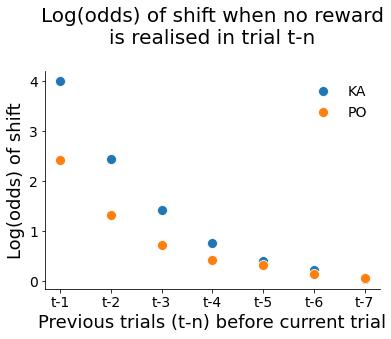

In [22]:
fig, axes = plt.subplots(facecolor = 'white')

data = coefficients.loc[coefficients.index[:-1], :] ## omitting the intercrept from the dataset

sns.scatterplot(data = data, x = data.index, y ='ka', s = 100, label = 'KA')# x = coeffs.index
sns.scatterplot(data = data, x = data.index, y ='po', s = 100, label = 'PO')# x = coeffs.index

plt.xlabel('Previous trials (t-n) before current trial', fontsize=18);
plt.ylabel('Log(odds) of shift', fontsize=18)
plt.xticks(fontsize=14)

plt.yticks([4, 3, 2, 1, 0], fontsize=14)

sns.despine()
plt.legend(frameon = False, fontsize = 14)


plt.title('Log(odds) of shift when no reward\nis realised in trial t-n', y = 1.1, size = 20);
#plt.title('Influence of previously realised \nrewards on policy change', y = 1.1, size = 20);

In [23]:
#fig.savefig(fig_save_path + 'n_back_trial_both.png', dpi = 300, bbox_inches='tight');

## Plot the coefficients as log odds and as probabilities

In [24]:
def get_prob(log_odds):
    prob = np.exp(log_odds)/(1+np.exp(log_odds))
    return prob

In [25]:
get_prob(coefficients_inter.loc['intercept', 'ka'])

0.2705383626468817

## Plot the predicted probabilities

In [26]:
## Érdemes lenne sanity check-ként a probability of stay-re is lefuttatni, és megnézni, hogy 1-beta-kat kapok-e. 

In [27]:
coefficients_inter2 = coefficients_inter.reset_index()

In [28]:
ka_summed_coeffs = [coefficients_inter2.loc[item: , 'ka'].sum() for item in coefficients_inter2.index]
ka_probs = get_prob(ka_summed_coeffs)


po_summed_coeffs = [coefficients_inter2.loc[item: , 'po'].sum() for item in coefficients_inter2.index]
po_probs = get_prob(po_summed_coeffs)

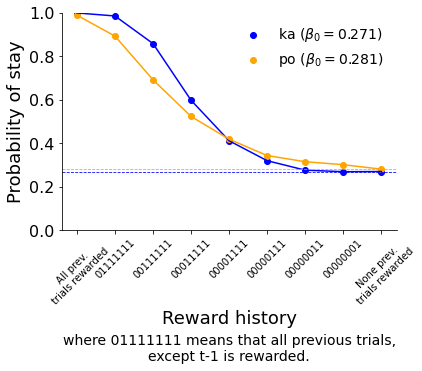

In [29]:
fig, ax = plt.subplots(1, 1, facecolor = 'white')


plt.scatter(range(1,10), ka_probs, label = r'ka ($\beta_0 = ${:.3f})'.format(ka_probs[-1]), color = 'blue')
plt.plot(range(1,10), ka_probs, color = "blue")
plt.scatter(range(1,10), po_probs, label = r'po ($\beta_0 = ${:.3f})'.format(po_probs[-1]), color = 'orange')
plt.plot(range(1,10), po_probs, color = 'orange')

sns.despine()

plt.yticks(np.arange(0, 1.2, 0.2), fontsize = 16)
plt.ylabel('Probability of stay', fontsize = 18)


plt.xticks(np.arange(1, 10, 1), 
           labels = ['All prev.\ntrials rewarded','01111111',
                                                  '00111111',
                                                  '00011111',
                                                  '00001111',
                                                  '00000111',
                                                  '00000011',
                                                  '00000001',
                                                  'None prev.\ntrials rewarded'], rotation = 45, fontsize = 10)



plt.xlabel('Reward history', fontsize = 18)
plt.text(5, -0.6, 'where 01111111 means that all previous trials,\nexcept t-1 is rewarded.',
         horizontalalignment = 'center',
         fontsize = 14)


plt.axhline(y = ka_probs[-1], color = 'blue', linestyle = 'dashed', lw = 0.8)
plt.axhline(y = po_probs[-1], color = 'orange', linestyle = 'dashed', lw = 0.8)


plt.legend(frameon = False, fontsize = 14)

plt.ylim(0, 1);

plt.savefig(fig_save_path + 'prob_stay_ka_po.png', dpi = 300, bbox_inches='tight')

## Empirical switch probability

In [25]:
## get eight digit reward history
def get_eight_digit_reward_hist(t1, t2, t3, t4, t5, t6, t7, t8):
    return str(np.array([t1, t2, t3, t4, t5, t6, t7, t8])).replace('[', '').replace(']', '').replace(' ', '').replace('.', '')

ka_data['8_digit_rhist'] = ka_data.apply(lambda x: get_eight_digit_reward_hist(x['t-1'],
                                                                               x['t-2'], 
                                                                               x['t-3'],
                                                                               x['t-4'],
                                                                               x['t-5'],
                                                                               x['t-6'],
                                                                               x['t-7'],
                                                                               x['t-8']), axis = 1)
#ka_data[['t-1', 't-2', 't-3','t-4','t-5','t-6','t-7','t-8', '8_digit_rhist']]

In [26]:
def get_empiric_prob_stay(condition):
    
    empirical_probs = {}
    
    if len(condition) != 8:
        raise Exception("Condition should be an eight digit string.")
    
    '''
    Calcualte the empirical probability of stay. The argument of the function is 'condition' that
    defines the reward history as an 8-digit string.
    
    It returns three items: 
        - nr. of matching conditions
        - nr. of matching & decide to stay with the current policy
        - prob. stay
        
    
    '''
    nr_matching_cond = ka_data.loc[ka_data['8_digit_rhist'] == condition].shape[0]
    nr_match_and_stay = ka_data.loc[(ka_data['8_digit_rhist'] == condition) & 
                                (ka_data['stay'] == 1)].shape[0]

    return (nr_matching_cond, nr_match_and_stay, nr_match_and_stay/nr_matching_cond)

In [27]:
ones = [i*'1' for i in range(8, -1, -1)]
conditions = [(8-len(item))*'0'+item for item in ones]

In [28]:
empirical_probs = {'reward_history':[],
                   'nr_matching_cond':[],
                   'nr_match_and_stay':[],
                   'empiric_prob_stay':[],
                   }

for condition in conditions: 
    nr_matching_cond, nr_match_and_stay, prob_stay = get_empiric_prob_stay(condition)
    empirical_probs['reward_history'].append(condition)
    empirical_probs['nr_matching_cond'].append(nr_matching_cond)
    empirical_probs['nr_match_and_stay'].append(nr_match_and_stay)
    empirical_probs['empiric_prob_stay'].append(prob_stay)

empirical_probabilities = pd.DataFrame(empirical_probs)
empirical_probabilities

,reward_history,nr_matching_cond,nr_match_and_stay,empiric_prob_stay
0,11111111,115,115,1.000000
1,01111111,159,158,0.993711
2,00111111,194,181,0.932990
3,00011111,122,81,0.663934
4,00001111,89,28,0.314607
5,00000111,87,26,0.298851
6,00000011,88,31,0.352273
7,00000001,104,26,0.250000
8,00000000,123,37,0.300813


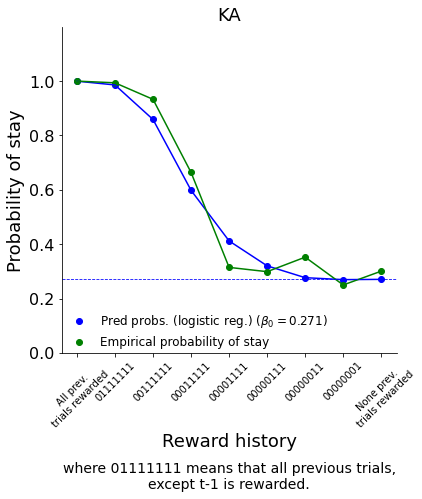

In [29]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6), facecolor = 'white')


plt.scatter(range(1,10), ka_probs, label = r'Pred probs. (logistic reg.) ($\beta_0 = ${:.3f})'.format(ka_probs[-1]), color = 'blue')
plt.plot(range(1,10), ka_probs, color = "blue")
plt.scatter(range(1,10), empirical_probabilities.empiric_prob_stay, label = 'Empirical probability of stay', color = 'green')
plt.plot(range(1,10), empirical_probabilities.empiric_prob_stay.to_list(), color = "green")



sns.despine()

plt.yticks(np.arange(0, 1.2, 0.2), fontsize = 16)
plt.ylabel('Probability of stay', fontsize = 18)


plt.xticks(np.arange(1, 10, 1), 
           labels = ['All prev.\ntrials rewarded','01111111',
                                                  '00111111',
                                                  '00011111',
                                                  '00001111',
                                                  '00000111',
                                                  '00000011',
                                                  '00000001',
                                                  'None prev.\ntrials rewarded'], rotation = 45, fontsize = 10)



plt.xlabel('Reward history', fontsize = 18)
plt.text(5, -0.5, 'where 01111111 means that all previous trials,\nexcept t-1 is rewarded.',
         horizontalalignment = 'center',
         fontsize = 14)


plt.axhline(y = ka_probs[-1], color = 'blue', linestyle = 'dashed', lw = 0.8)
plt.legend(frameon = False, fontsize = 12, loc = (0,0))

plt.ylim(0, 1.2);
plt.title('KA', fontsize = 18)

plt.savefig(fig_save_path + 'KA_log_reg_pred_and_empirical_prob_stay.png', dpi = 300, bbox_inches='tight')

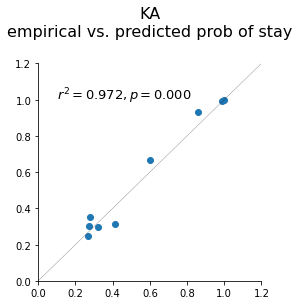

In [30]:
fig, ax = plt.subplots(1, 1, figsize = (4, 4), facecolor = 'white')

results = scipy.stats.pearsonr(ka_probs, empirical_probabilities.empiric_prob_stay.to_list())

plt.scatter(ka_probs, empirical_probabilities.empiric_prob_stay.to_list())
plt.plot([0,1.2],[0,1.2], lw = 0.2, color = 'black')
plt.xlim(0, 1.2)
plt.ylim(0, 1.2)
sns.despine()


plt.text(0.1, 1, r'$r^2 ={:.3f}, p ={:.3f}$'.format(results.statistic**2, results.pvalue), fontsize = 13) 

plt.title('KA\nempirical vs. predicted prob of stay', fontsize = 16, y = 1.1);

plt.savefig(fig_save_path + 'KA_log_reg_pred_and_empirical_prob_correlation.png', dpi = 300, bbox_inches='tight')

## Probability of switch based on action value

In [31]:
def min_max_scaling(data):
    min_val = np.min(data)
    max_val = np.max(data)
    scaled_data = (data - min_val) / (max_val - min_val)
    return (scaled_data)

In [32]:
def get_action_value (data, monkey, normalised = False): 
    
    '''
    '''
    
    cols = ['t-'+str(item) for item in range(1,9)]
    weights = np.array(coefficients_inter2.loc[0:7, monkey])
    fb_hist = np.array(data.loc[8:, cols])
    weigted_trials = fb_hist*weights
    action_value = weigted_trials.sum(axis = 1)
    action_value = action_value+coefficients_inter.loc['intercept', monkey]
    
    
    if normalised == False: 
        return action_value 
    
    if normalised == True: 
        return min_max_scaling(action_value)
    
    

In [33]:
action_value = get_action_value(ka_data, 'ka', normalised = False)
print(action_value.shape, action_value.min(), action_value.max())

(22959,) -0.9966717396255863 8.240678962306555


In [34]:
action_value_norm = get_action_value(ka_data, 'ka', normalised = True)
print(action_value_norm.shape, action_value_norm.min(), action_value_norm.max())

(22959,) 0.0 1.0


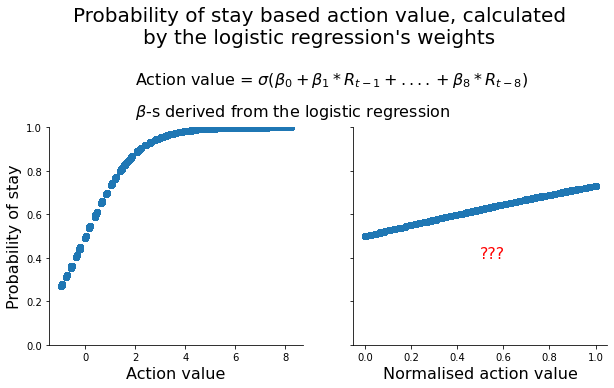

In [35]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4), facecolor = 'white', sharey = True)

ax[0].scatter(action_value, get_prob(action_value))
ax[0].set_ylim(0, 1)
ax[0].set_ylabel('Probability of stay', fontsize = 16)
ax[0].set_xlabel('Action value', fontsize = 16)


ax[0].text(2, 1.2, r'Action value = $\sigma(\beta_{0}+\beta_{1}*R_{t-1}+....+\beta_{8}*R_{t-8}) $', fontsize = 16)
ax[0].text(2, 1.05, r'$\beta$-s derived from the logistic regression', fontsize = 16)


ax[1].scatter(action_value_norm, get_prob(action_value_norm))
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Normalised action value', fontsize = 16)

ax[1].text(0.5, 0.4, '???', fontsize = 16, color = 'red')



sns.despine();
plt.suptitle('Probability of stay based action value, calculated\nby the logistic regression\'s weights', fontsize = 20, y = 1.3);
plt.savefig(fig_save_path + 'Probability of stay based on log.reg.coeffs.png', dpi = 300, bbox_inches='tight')

In [36]:
# coefficients_inter2 = coefficients_inter.reset_index()

# ka_summed_coeffs = [coefficients_inter2.loc[item: , 'ka'].sum() for item in coefficients_inter2.index]
# ka_probs = get_prob(ka_summed_coeffs)

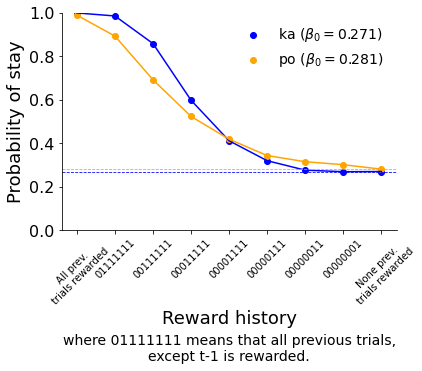

In [37]:
fig, ax = plt.subplots(1, 1, facecolor = 'white')


plt.scatter(range(1,10), ka_probs, label = r'ka ($\beta_0 = ${:.3f})'.format(ka_probs[-1]), color = 'blue')
plt.plot(range(1,10), ka_probs, color = "blue")
plt.scatter(range(1,10), po_probs, label = r'po ($\beta_0 = ${:.3f})'.format(po_probs[-1]), color = 'orange')
plt.plot(range(1,10), po_probs, color = 'orange')

sns.despine()

plt.yticks(np.arange(0, 1.2, 0.2), fontsize = 16)
plt.ylabel('Probability of stay', fontsize = 18)


plt.xticks(np.arange(1, 10, 1), 
           labels = ['All prev.\ntrials rewarded','01111111',
                                                  '00111111',
                                                  '00011111',
                                                  '00001111',
                                                  '00000111',
                                                  '00000011',
                                                  '00000001',
                                                  'None prev.\ntrials rewarded'], rotation = 45, fontsize = 10)



plt.xlabel('Reward history', fontsize = 18)
plt.text(5, -0.6, 'where 01111111 means that all previous trials,\nexcept t-1 is rewarded.',
         horizontalalignment = 'center',
         fontsize = 14)


plt.axhline(y = ka_probs[-1], color = 'blue', linestyle = 'dashed', lw = 0.8)
plt.axhline(y = po_probs[-1], color = 'orange', linestyle = 'dashed', lw = 0.8)


plt.legend(frameon = False, fontsize = 14)

plt.ylim(0, 1);

plt.savefig(fig_save_path + 'prob_stay_ka_po.png', dpi = 300, bbox_inches='tight')

## Check out specific cases

In [41]:
ka_data.loc[(ka_data['t-1'] == 0) &
           (ka_data['t-2'] == 0) &
           (ka_data['t-3'] == 0) &
           (ka_data['t-4'] == 0) &
           (ka_data['t-5'] == 0) &
           (ka_data['t-6'] == 0) &
           (ka_data['t-7'] == 0) &
           (ka_data['t-8'] == 0)].shape[0]

123

In [44]:
non_rev_8back = ka_data.loc[(ka_data['t-1'] == 0) &
           (ka_data['t-2'] == 0) &
           (ka_data['t-3'] == 0) &
           (ka_data['t-4'] == 0) &
           (ka_data['t-5'] == 0) &
           (ka_data['t-6'] == 0) &
           (ka_data['t-7'] == 0) &
           (ka_data['t-8'] == 0)& 
            (ka_data['stay'] == 1) 
           ].index

In [47]:
print(len(non_rev_8back))
non_rev_8back

37


Index([  878,  2335,  3049,  3053,  3068,  3208,  3212,  3476,  3477,  3478,
        3480,  4018,  4019,  4020,  4725,  4728,  4729,  6025,  7691,  8313,
        9103, 10353, 12248, 12249, 12512, 12513, 12515, 12516, 12529, 13930,
       15783, 16642, 17319, 19953, 20973, 22342, 22849],
      dtype='int64')

In [56]:
idx = non_rev_8back[5]

ka_data.loc[idx-8:idx]

,monkey,session,trial_id,block_id,best_target,target,feedback,_shift,stay,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,8_digit_rhist
3200,ka,150720,111,2,3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,00001110
3201,ka,150720,112,2,3,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,00000111
3202,ka,150720,113,2,3,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,00000011
3203,ka,150720,114,2,3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,00000001
3204,ka,150720,115,2,3,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00000000
3205,ka,150720,116,2,3,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00000000
3206,ka,150720,117,2,3,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00000000
3207,ka,150720,118,2,3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00000000
3208,ka,150720,119,2,3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00000000
